# Prediction of AAPL stock using LR with ARMA errors (2006-2019)

<font color='red'>Based on the result in 01 notebook, the price in 2020 increases almost by 100% and it strongly affects the prediction model. So I remove the data after 2020. Also, for the accuracy, I decide to also include data before the financial crisis in 2008.</font>

## Content
0. [Download Data from Yahoo Finance](#section0)
1. [Data preparation (LOWESS smoother)](#section1)
2. [Exploratory Data Analysis](#section2)
3. [Data Testing](#section3)
4. [Fitting an ARMA model](#section4)
5. [Residual Analysis](#section5)
6. [Prediction vs. Realized Values](#section6)

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime

### <a id='section0'></a> 0 $\bullet$ Import Apple Stock data from Yahoo Finance

In [2]:
start = '2006-01-01'
end = '2020-01-01'

In [3]:
aapl_df = yf.download(tickers='AAPL', start=start, end=end, interval='1wk')
print(aapl_df.head())
print(aapl_df.tail())
print(aapl_df.shape[0])

[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close        Volume
Date                                                                       
2006-01-02  2.585000  2.739286  2.580357  2.725000   2.343235  2.580718e+09
2006-01-09  2.740357  3.085714  2.705000  3.056786   2.628540  6.505820e+09
2006-01-16  3.060714  3.085000  2.708214  2.717500   2.336786  4.866868e+09
2006-01-23  2.717857  2.841429  2.539286  2.572500   2.212100  5.613023e+09
2006-01-30  2.541786  2.735714  2.531071  2.566071   2.206571  4.232575e+09
                 Open       High        Low      Close  Adj Close       Volume
Date                                                                          
2019-12-02  66.817497  67.750000  64.072502  67.677498  66.884315  456599200.0
2019-12-09  67.500000  68.824997  66.227501  68.787498  67.981300  568117600.0
2019-12-16  69.250000  70.662498  69.245003  69.860001  69.041237  732720000.0
2019

### <a id='section1'></a> 1 $\bullet$ Data preparation

#### Check missing values

In [4]:
miss = aapl_df.isnull().sum()
print('no missing values' if miss.sum() == 0 else 'there are %d missing values' % miss.sum())
aapl_df[aapl_df.isna().any(axis=1)].head()

there are 186 missing values


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-08-09,NaN,NaN,NaN,NaN,NaN,NaN
2012-11-07,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-07,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-09,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-08,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
aapl_df = aapl_df.dropna()  # remove the missing value rows

#### Date in the dataframe is set as index
Check the possible frequency of the index (date)

In [6]:
pd.infer_freq(aapl_df.index)

'W-MON'

#### LOWESS Smoothing

Use lowess smoother to have a better prediction of data.
https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html

In [7]:
import statsmodels.nonparametric.smoothers_lowess as les

# to produce a smoother array using LOWESS
def lowess_smoother(x, y, frac=0.1):
    smo_res = les.lowess(endog=y, exog=x, frac=frac)
    smo_list = []
    for i in smo_res:
        smo_list.append(i[1])
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(y=smo_list, x=x)
    return smo_list

Plot the original price and the price after LOWESS smoothing

C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\core\frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


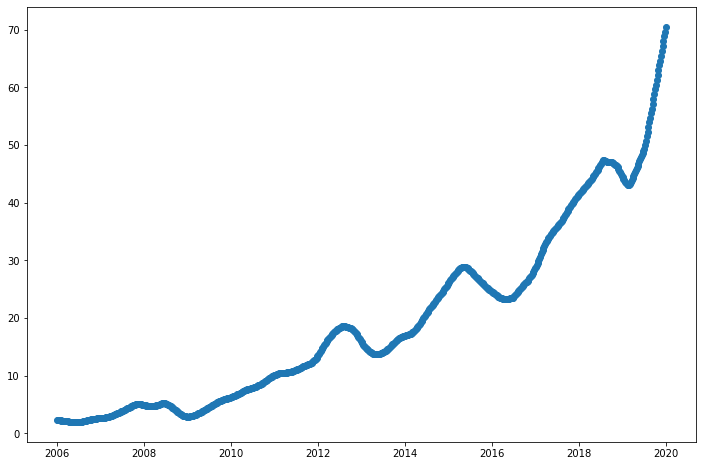

In [8]:
lowess_price = lowess_smoother(x=aapl_df.index, y=aapl_df['Adj Close'], frac=0.05)
aapl_df.rename(columns={'Adj Close': 'Original_Adj_Close'}, inplace=True)
aapl_df.insert(loc=4, column='Adj Close', value=lowess_price)

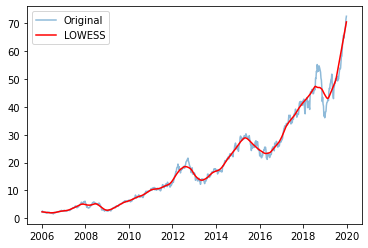

In [9]:
fig, ax = plt.subplots()
ax.plot(aapl_df.index, aapl_df['Original_Adj_Close'], label='Original', alpha=0.5)
ax.plot(aapl_df.index, aapl_df['Adj Close'], label='LOWESS', color='red')
ax.legend()

#### Maximum drawdown

<AxesSubplot:xlabel='date'>

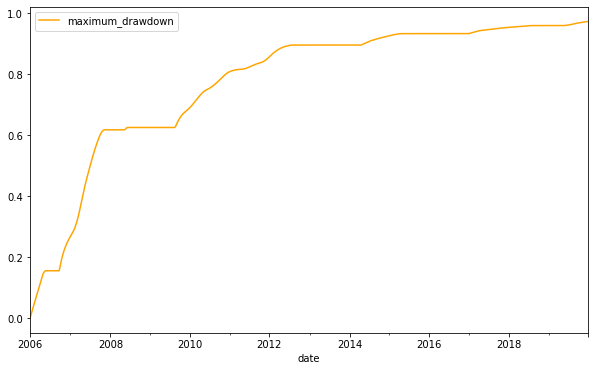

In [10]:
df0 = pd.DataFrame(index=['date'], columns=['maximum_drawdown'])
for i in aapl_df.index:
    maxdd_i = (aapl_df[:i]['Adj Close'].max() - aapl_df[:i]['Adj Close'].min()) / aapl_df[:i]['Adj Close'].max()
    df0 = pd.concat([df0, pd.DataFrame({'date': [i], 'maximum_drawdown': [maxdd_i]})], axis=0)
df0.set_index('date', inplace=True)
df0.dropna(inplace=True)

df0.plot(figsize=(10,6), c='orange')

#### Calculate arithmetic return

In [11]:
week_rt = (aapl_df['Adj Close']/aapl_df['Adj Close'].shift(1) - 1).rename('Weekly Return')
aapl_df = pd.concat([aapl_df, week_rt], axis=1)
year_rt = aapl_df['Adj Close']/aapl_df['Adj Close'].shift(52) - 1

#### Plot prices and return

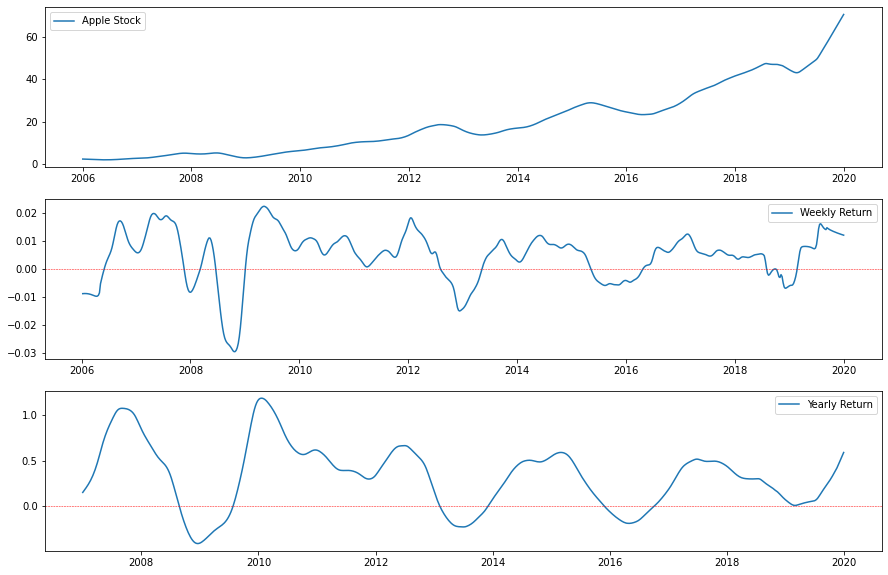

In [12]:
fig, ax = plt.subplots(3, figsize=(15, 10))
ax[0].plot(aapl_df['Adj Close'])
ax[1].plot(week_rt)
ax[2].plot(year_rt)
ax[1].axhline(y=0, c="r", linewidth=0.5, linestyle='--')
ax[2].axhline(y=0, c="r", linewidth=0.5, linestyle='--')
ax[0].legend(['Apple Stock'])
ax[1].legend(['Weekly Return'])
ax[2].legend(['Yearly Return'])

### <a id='section2'></a> 2 $\bullet$ Exploratory Data Analysis

#### Trend of other tech stocks (before smoothing)

In [13]:
tech_df = yf.download(tickers='AAPL IBM MSFT F', start=start, end=end, interval='1d')  # daily frequency

[*********************100%***********************]  4 of 4 completed


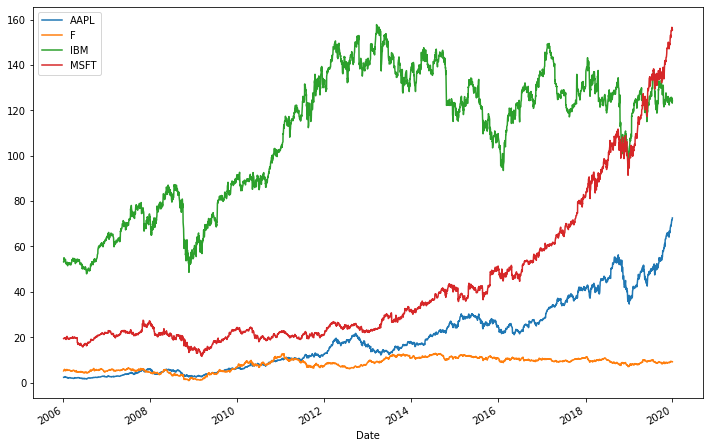

In [14]:
tech_df['Adj Close'].plot(figsize=(12,8))
del tech_df

#### Histograms

Text(0.5, 1.0, 'AAPL weekly return')

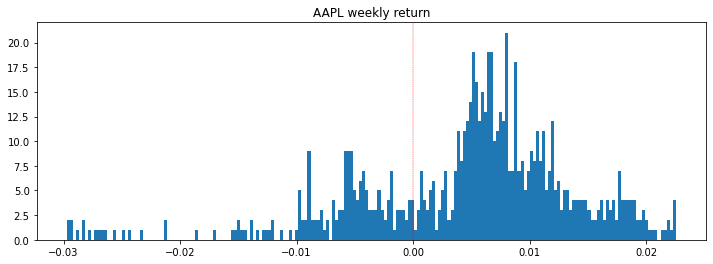

In [15]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.hist(week_rt, bins=200)
ax.axvline(x=0, c="r", linewidth=0.4, linestyle='--')
plt.title('AAPL weekly return')

#### Histogram with Kernel Density Estimate (KDE)

Text(0.5, 1.0, 'AAPL weekly return')

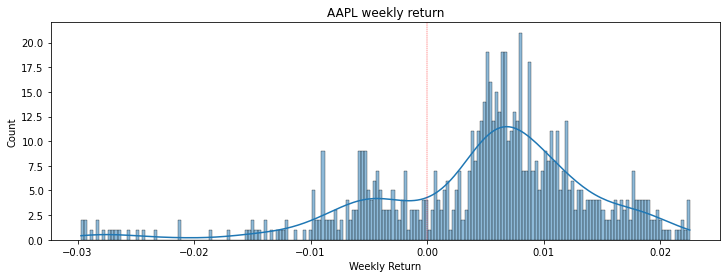

In [16]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.histplot(x=week_rt, kde=True, bins=200, ax=ax)
ax.axvline(x=0, c="r", linewidth=0.4, linestyle='--')
plt.title('AAPL weekly return')

#### Empirical cumulative density function

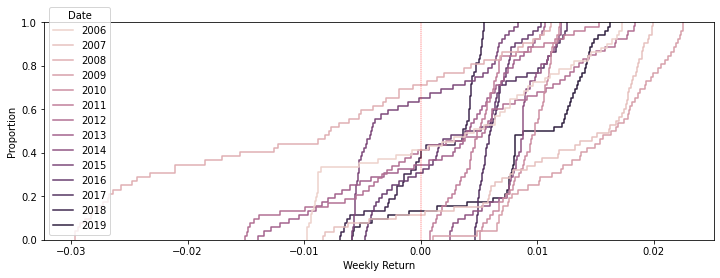

In [17]:
fig, ax = plt.subplots(figsize=(12,4))
sns.ecdfplot(data=aapl_df, x=week_rt, hue=aapl_df.index.year, ax=ax)
ax.axvline(x=0, c="r", linewidth=0.4, linestyle='--')

#### Stacked histogram

Plot the histogram of the AAPL weekly returns, adding a hue for the different years and stacking the different years.

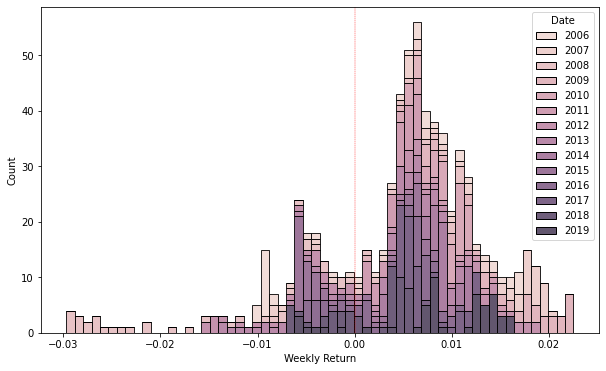

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(data=aapl_df, x=week_rt, hue=aapl_df.index.year, multiple='stack', bins=60, ax=ax)
ax.axvline(x=0, c="r", linewidth=0.4, linestyle='--')

#### Boxplot

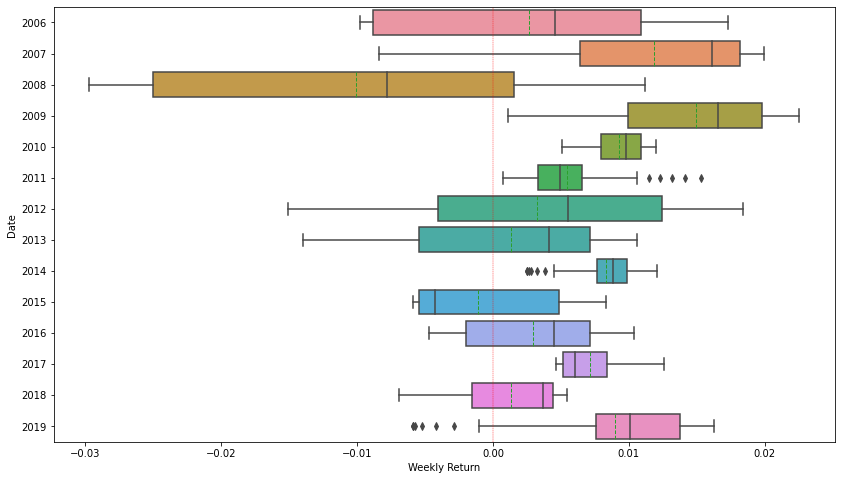

In [19]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(x=week_rt, y=aapl_df.index.year, orient='h',
            showmeans=True, meanline=True, ax=ax)
ax.axvline(x=0, c="r", linewidth=0.4, linestyle='--')

#### Scatterplot

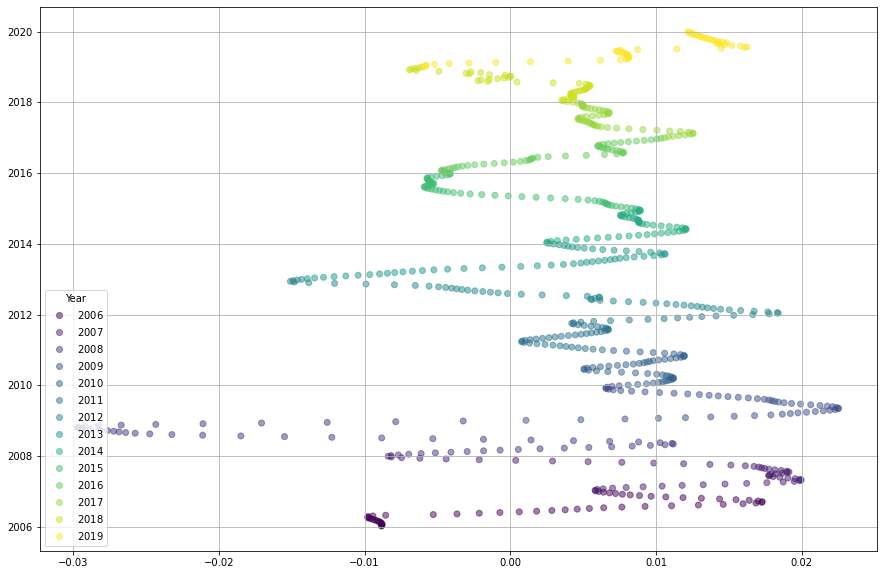

In [20]:
# plt.scatter(x=week_rt, y=aapl_df.index, c=aapl_df.index.year, alpha=0.5)
# plt.legend(aapl_df.index.year)
fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(x=week_rt, y=aapl_df.index, c=aapl_df.index.year, alpha=0.5)
ax.legend(*scatter.legend_elements(),
                    loc='lower left', title='Year')
ax.grid()

### <a id='section3'></a> 3 $\bullet$ Data testing

#### Test for stationarity

In [21]:
from statsmodels.tsa.api import adfuller, kpss, acf

Augmented Dickey-Fuller stationarity test (null hypothesis: non-stationarity)

In [22]:
def print_adf_test(x):
    regressions = {'constant only': 'c',
                   'constant and trend': 'ct',
                   'constant, and linear and quadratic trend': 'ctt',
                   'no constant, no trend': 'nc'}
    df = pd.DataFrame(data=np.zeros((len(regressions),2)),
                      index=regressions,
                      columns=['test statistic', 'p-value'])
    for reg in regressions:
        res = adfuller(x, regression=regressions[reg])
        df.loc[reg, 'test statistic'] = res[0]
        df.loc[reg, 'p-value'] = res[1]
    display(df.round(4))
    return df

In [23]:
adf_test_price = print_adf_test(aapl_df['Adj Close'])  # ADF test for weekly price

,test statistic,p-value
constant only,2.4470,0.9990
constant and trend,0.7744,1.0000
"constant, and linear and quadratic trend",-2.0028,0.8157
"no constant, no trend",3.1800,0.9999


p-value > 0.05, **we cannot reject the null hypothesis of non-stationarity**.

In [24]:
adf_test_rt = print_adf_test(week_rt.dropna())  # ADF test for weekly return

,test statistic,p-value
constant only,-3.7112,0.0040
constant and trend,-3.6709,0.0243
"constant, and linear and quadratic trend",-3.6806,0.0738
"no constant, no trend",-3.0255,0.0025


p-value < 0.05, reject the null hypothesis of non-stationarity. **The weekly return of AAPL is stationary.**

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test (Null hypothesis: stationarity)

In [25]:
def print_kpss_test(x, regression='c'):
    regressions = {'constant only': 'c',
                   'constant and trend': 'ct'}
    df = pd.DataFrame(data=np.zeros((len(regressions),2)),
                      index=regressions,
                      columns=['test statistic', 'p-value'])
    for reg in regressions:
        res = kpss(x, regression=regressions[reg], nlags='auto')
        df.loc[reg, 'test statistic'] = res[0]
        df.loc[reg, 'p-value'] = res[1]
    display(df.round(4))
    return df

In [26]:
print_kpss_test(aapl_df['Adj Close'])  # KPSS test for weekly price

C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


,test statistic,p-value
constant only,3.7724,0.01
constant and trend,0.6822,0.01


,test statistic,p-value
constant only,3.772435,0.01
constant and trend,0.682192,0.01


p-value < 0.01, **we have 99% confidence to reject the null hypothesis of stationarity**.

In [27]:
print_kpss_test(week_rt.dropna())  # KPSS test for weekly return

C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,test statistic,p-value
constant only,0.0512,0.1
constant and trend,0.0473,0.1


,test statistic,p-value
constant only,0.051241,0.1
constant and trend,0.047340,0.1


p-value > 0.1, we cannot reject the null hypothesis of stationarity. **The weekly return is stationary.**

#### Test for autocorrelation

Autocorrelation function ACF:
    $$\rho(h) = \frac{\gamma(h)}{\gamma(0)}$$
    where $$\gamma(h) = Cov(X_t, X_{t-h})$$

$\bullet$ Individual test for some h > 0, 
$$H_0: \rho(h) = 0$$
$$H_1: \rho(h) ≠ 0$$

In practice, one need at least T ⩾ 50 (T is the number of observations) and h ⩽ T/4. In this case T = 1153, so h ⩽ 288.

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [29]:
def acf_pacf(x, lags=50):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    plot_acf(x, lags=lags, ax=ax[0])
    plot_pacf(x, lags=lags, ax=ax[1])
    
    # add the 95% confidence interval using variance = 1/N
    stderr = stats.norm.ppf(.975) / np.sqrt(len(x))
    ax[0].hlines([stderr, -stderr], 0, lags, colors='r', linestyles='dotted', label='95% confidence interval')
    ax[1].hlines([stderr, -stderr], 0, lags, colors='r', linestyles='dotted', label='95% confidence interval')
    
    ax[0].legend()
    ax[1].legend()
    
    return fig

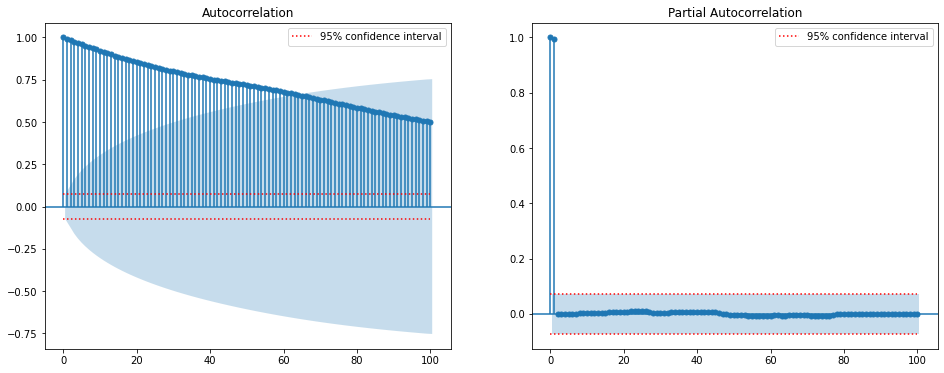

In [30]:
acf_plot_price = acf_pacf(aapl_df['Adj Close'], lags=100)

As lag increases, the autocorrelation effect decreases; but clearly when the lags are small, the autocorrelation is strong. Because all the  For partial autocorrelation, the situation is much better, but when lag = 1 and when lag = 2, there are still a high autocorrelation effect. **We can conclude that the stock price of AAPL is not white noise.**

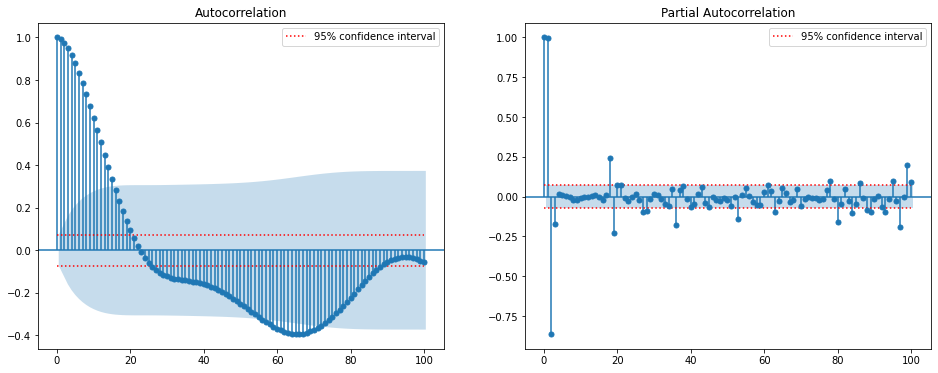

In [31]:
acf_plot_rt = acf_pacf(week_rt.dropna(), lags=100)

We can conclude that **weekly return is not white noise.**

$\bullet$ Joint test: the Ljung–Box Q test
For some m << T,
$$\begin{align}
H_0: \rho(1) = ... = \rho(m) = 0\\
H_1: \exists 1 ≤ h ≤ m,\rho(h) ≠ 0 \\
\end{align}$$

In [32]:
def print_acf(x, lags):
    val, qstat, pval = acf(x, fft=False, qstat=True, nlags=lags.max())
    df = pd.DataFrame(np.array([qstat[lags-1], 100 * pval[lags-1]]).T,
                      columns=['Q Statistic', 'p-value (%)'],
                      index=[f'up to lag {lag}' for lag in lags]).round(2)
    display(df)
    return df

In [33]:
lags = np.array([1, 2, 3, 5, 7, 10, 20])
res1 = print_acf(aapl_df['Adj Close'], lags)

,Q Statistic,p-value (%)
up to lag 1,722.12,0.0
up to lag 2,1433.52,0.0
up to lag 3,2134.36,0.0
up to lag 5,3504.98,0.0
up to lag 7,4835.31,0.0
up to lag 10,6758.38,0.0
up to lag 20,12604.55,0.0


We can reject the null hypothesis that autocorrelation does not exist. So **weekly price is not a white noise.**

In [34]:
res2 = print_acf(week_rt.dropna(), lags)

,Q Statistic,p-value (%)
up to lag 1,722.71,0.0
up to lag 2,1422.18,0.0
up to lag 3,2086.59,0.0
up to lag 5,3275.57,0.0
up to lag 7,4244.77,0.0
up to lag 10,5271.26,0.0
up to lag 20,6195.05,0.0


We can reject the null hypothesis that autocorrelation does not exist. So **weekly return is not white noise.**

### <a id='section4'></a> 4 $\bullet$ Fitting an ARMA model

$\bullet$ Selecting a model with information criteria 
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.arma_order_select_ic.html  
`trend='c'` includes constant  
`trend='nc'` no constant: long run mean is zero

In [35]:
from statsmodels.tsa import stattools

# Silence the warning
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [36]:
def select_arma(x, max_ar=2, max_ma=2, trend='c'):
    res = stattools.arma_order_select_ic(x, max_ar=max_ar, max_ma=max_ma, ic=['aic', 'bic'], trend=trend)
    res['aic'].index.names = ['AR Lags']
    res['aic'].columns.names = ['MA Lags']
    res['bic'].index.names = ['AR Lags']
    res['bic'].columns.names = ['MA Lags']
    res['aic'].columns = pd.MultiIndex.from_product([['AIC'],res['aic'].columns])
    res['bic'].columns = pd.MultiIndex.from_product([['BIC'],res['bic'].columns])

    display(res['aic'].round(1))
    print('AIC selected order: ', res['aic_min_order'])
    display(res['bic'].round(1))
    print('BIC selected order: ', res['bic_min_order'])
    
    return res

In [37]:
res = select_arma(aapl_df['Adj Close'], max_ar=4, max_ma=4, trend='c')

C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov

C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting 

AIC                                
MA Lags       0       1       2       3       4
AR Lags                                        
0        6104.9  5106.1  4113.0  3136.7  2183.1
1        -182.6 -1173.0 -2126.7 -2888.1 -3449.0
2           NaN     NaN -1168.7 -2033.0 -2906.0
3       -4722.1   768.3     NaN -4025.7 -3591.8
4           NaN  1020.2 -2362.8 -3619.6 -4439.2

AIC selected order:  (3, 0)


BIC                                
MA Lags       0       1       2       3       4
AR Lags                                        
0        6114.1  5119.9  4131.4  3159.7  2210.7
1        -168.8 -1154.6 -2103.8 -2860.5 -3416.9
2           NaN     NaN -1141.2 -2000.8 -2869.3
3       -4699.2   795.8     NaN -3988.9 -3550.4
4           NaN  1052.4 -2326.1 -3578.2 -4393.2

BIC selected order:  (3, 0)


Based on the result of both information criteria, we fit ARMA(3, 0) model to the dataset.
https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.fit.html

In [38]:
import statsmodels.tsa.arima.model as smt_arima
model = smt_arima.ARIMA(aapl_df['Adj Close'], order=(3, 0, 0))  # ARMA function is deprecated

C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


In [39]:
fitted_model = model.fit()
fitted_model.summary()

C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                  731
Model:                 ARIMA(3, 0, 0)   Log Likelihood                1426.836
Date:                Sun, 06 Jun 2021   AIC                          -2843.671
Time:                        15:05:39   BIC                          -2820.699
Sample:                    01-02-2006   HQIC                         -2834.809
                         - 12-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.8110      9.587      2.067      0.039       1.021      38.601
ar.L1          0.9984      0.003    363.973      0.000       0.993       1.004
ar.L2          0.9999   6.78e-05   1.47e+04      0.000       1.000       1.000
ar.L3         -0.9984      0.003   -361.561      0.000      -1.004      -0.993
sigma2         0.0011   2.06e-05     55.140      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                 567.17   Jarque-Bera (JB):             18468.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              25.38   Skew:                             1.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### <a id='section5'></a> 5 $\bullet$ Residual Analysis

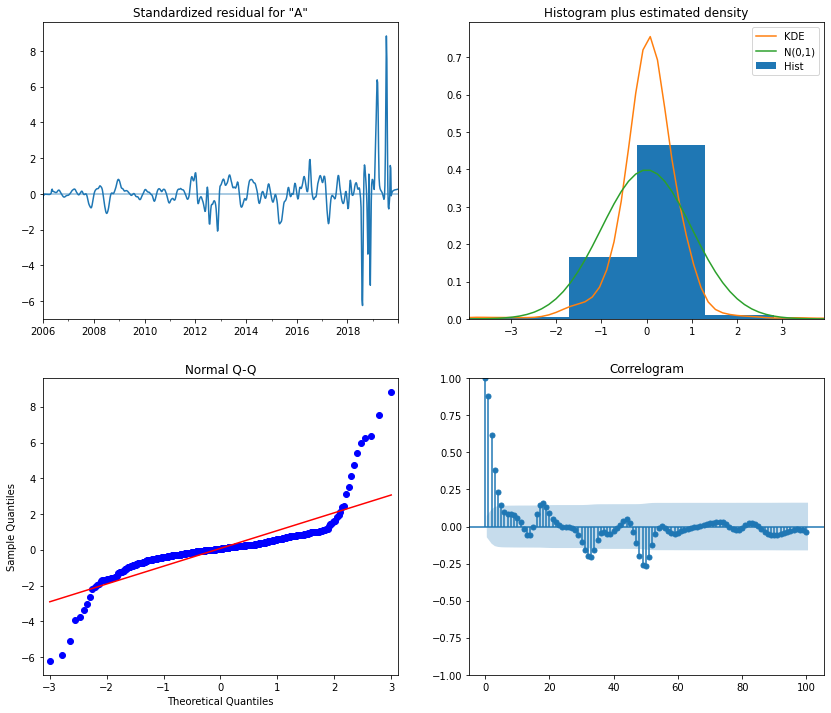

In [40]:
fig = fitted_model.plot_diagnostics(figsize=(14,12), lags=100)

We confirm the absence of autocorrelation seen in the Correlogram with the Ljung-Box Q Test.  
This proves that the ARMA model has captured most of the autocorrelation structure that is in the weekly price dataset.

In [41]:
res = print_acf(fitted_model.resid, lags)

,Q Statistic,p-value (%)
up to lag 1,0.02,89.61
up to lag 2,0.03,98.53
up to lag 3,0.03,99.86
up to lag 5,0.03,100.00
up to lag 7,0.03,100.00
up to lag 10,0.03,100.00
up to lag 20,0.03,100.00


p-value > 0.05, we cannot reject the null hypothesis of no autocorrelation.

### <a id='section6'></a> 6 $\bullet$ Prediction vs. Realized Values

In [42]:
forecast = fitted_model.get_forecast(steps=40)  # predict values for next 40 weeks (already happened)
f = forecast.summary_frame()
f.tail()

Adj Close,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-09-07,99.227638,2.134994,95.043126,103.412149
2020-09-14,99.972025,2.222858,95.615304,104.328746
2020-09-21,100.718071,2.307050,96.196335,105.239806
2020-09-28,101.456636,2.396863,96.758870,106.154402
2020-10-05,102.196837,2.483091,97.330068,107.063606


Plot the predicted values

In [43]:
realized_value = yf.Ticker('AAPL').history(start=min(f.index), end=max(f.index))

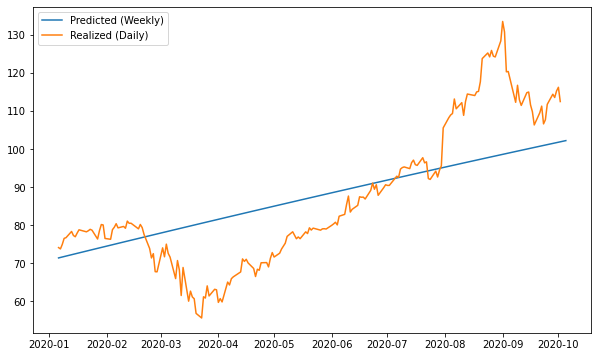

In [44]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(f['mean'], label='Predicted (Weekly)')
ax.plot(realized_value['Close'], label='Realized (Daily)')
ax.legend()